# Tracking the Experiment
This code is a basic illustration of how one can utilize TensorBoard with PyTorch for monitoring the training process. TensorBoard is a visualization tool provided with TensorFlow, but it can also be used with PyTorch through the torch.utils.tensorboard module. Here's a step-by-step breakdown of the code:

1. Imports:
torch: PyTorch's main module.
SummaryWriter: This is the interface used to log various types of information, which can then be visualized using TensorBoard.
2. Create a dummy model and optimizer:
A simple linear regression model (torch.nn.Linear) is defined with an input size of 10 and an output size of 1.
An optimizer (torch.optim.SGD) is instantiated to optimize the model's parameters using Stochastic Gradient Descent.
3. Instantiate SummaryWriter:
writer = SummaryWriter(): This initializes an instance of SummaryWriter. By default, it will save logs to the runs/ directory. These logs can later be visualized using TensorBoard.
4. Training loop:
The loop runs for 100 epochs.
For each epoch:
  * The optimizer's gradients are zeroed out using optimizer.zero_grad (). This is a standard step in PyTorch since gradients accumulate by default.
 * A forward pass is made with a batch of random data of size (32, 10).
  * A dummy loss is computed. It's the mean squared error between the model's output and another batch of random data. This represents a mock training scenario.
  * The loss is backpropagated using loss.backward().
  * The optimizer updates the model's parameters with optimizer.step().
5. Log the loss to TensorBoard:
  * For each epoch, the training loss is logged to TensorBoard using writer.add_scalar(). The first argument is the tag (a string to identify the scalar), the second is the scalar value, and the third is the x-coordinate (typically the epoch or iteration number).
6. Close the writer:
  * After logging everything, it's a good practice to close the writer using writer.close(). This ensures all data is flushed out and no resources are wasted.
To visualize the data in TensorBoard after running this script, you'd typically open a terminal and run:

7. Run the following command on terminal

```tensorboard --logdir=runs```
8. Then, open a browser and navigate to the provided URL (usually http://localhost:6006). There, you would see a plot of the "Training loss" over the 100 epochs.

In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter

# Create a dummy model and optimizer
model = torch.nn.Linear(10, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Instantiate SummaryWriter
writer = SummaryWriter()

for epoch in range(100):
    # Dummy training loop
    optimizer.zero_grad()
    output = model(torch.randn(32, 10))
    loss = ((output - torch.randn(32, 1))**2).mean()
    loss.backward()
    optimizer.step()

    # Log loss to TensorBoard
    writer.add_scalar("Training loss", loss, epoch)

# Close the writer
writer.close()



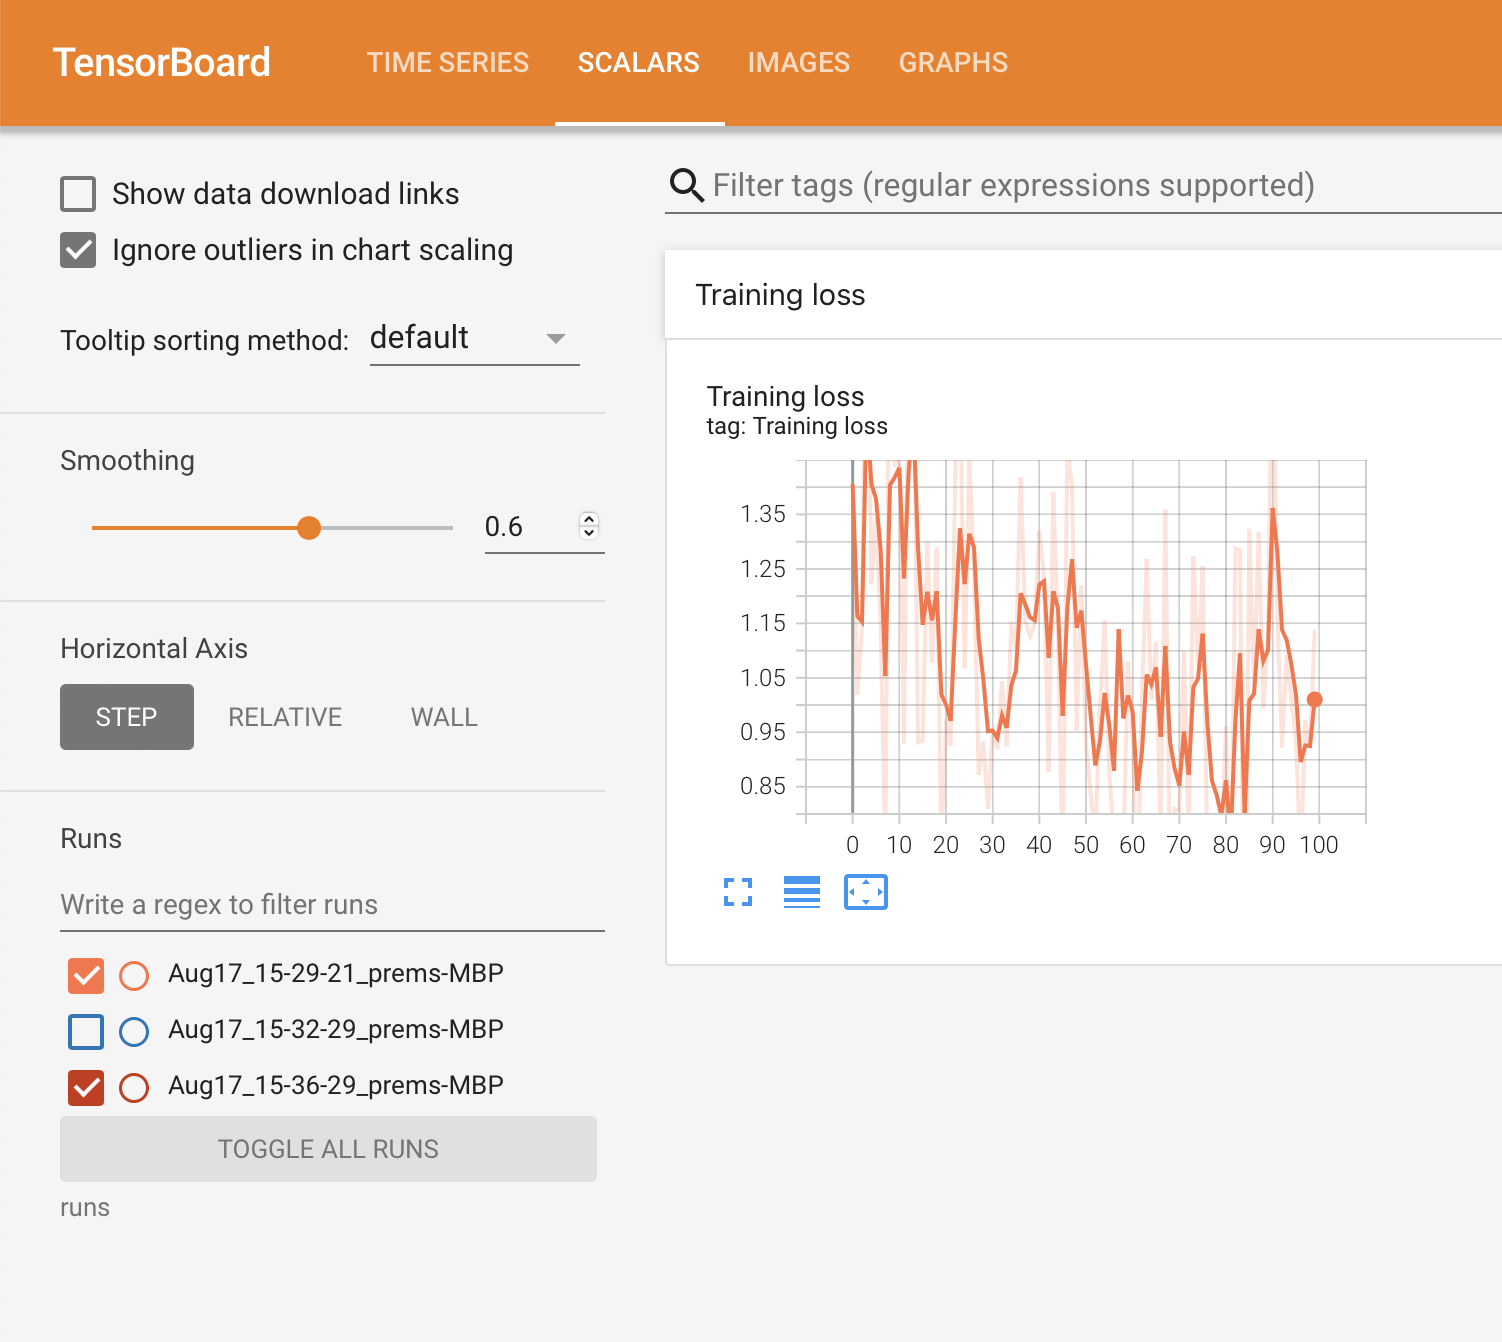

# Visualizing the Transformer Architecture
The most important thing to understand in below code is:
1. We have created wrapper around BERT and we are using Wrapper class instead of using BERT directly.
2. There might be an issue that directly tracing BertModel using torch.jit.trace (which is what writer.add_graph effectively does behind the scenes) can be problematic due to the way BERT (and many other Transformer models) is designed, especially with respect to the outputs they produce. If you use Transformer model directly, you might get following error:
```
RuntimeError: Encountering a dict at the output of the tracer might cause the trace to be incorrect...
```
3. This error arises because the BERT model returns a tuple which sometimes contains dictionaries, depending on the configuration and inputs, and TorchScript (the system behind torch.jit.trace) doesn't handle dynamic structures like this gracefully.
4. By using the SimpleBERT wrapper, you are effectively circumventing this issue. Instead of having to deal with the multiple outputs that BertModel can produce (like pooler_output, hidden_states, etc.), the SimpleBERT model simplifies things by only returning the last_hidden_state, which is a tensor. This makes the model's output more "TorchScript-friendly", allowing you to add the model's graph to TensorBoard without any issues.


In [6]:
import torch
from transformers import BertModel, BertTokenizer
from torch.utils.tensorboard import SummaryWriter

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
bert_model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

class SimpleBERT(torch.nn.Module):
    def __init__(self, bert_model):
        super(SimpleBERT, self).__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state

model = SimpleBERT(bert_model)

# Instantiate the SummaryWriter
writer = SummaryWriter()

# Create a dummy input for the BERT model
tokens = tokenizer("Hello, TensorBoard!", return_tensors="pt")
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

# Add the BERT model graph to TensorBoard
writer.add_graph(model, [input_ids, attention_mask])

# Close the writer
writer.close()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


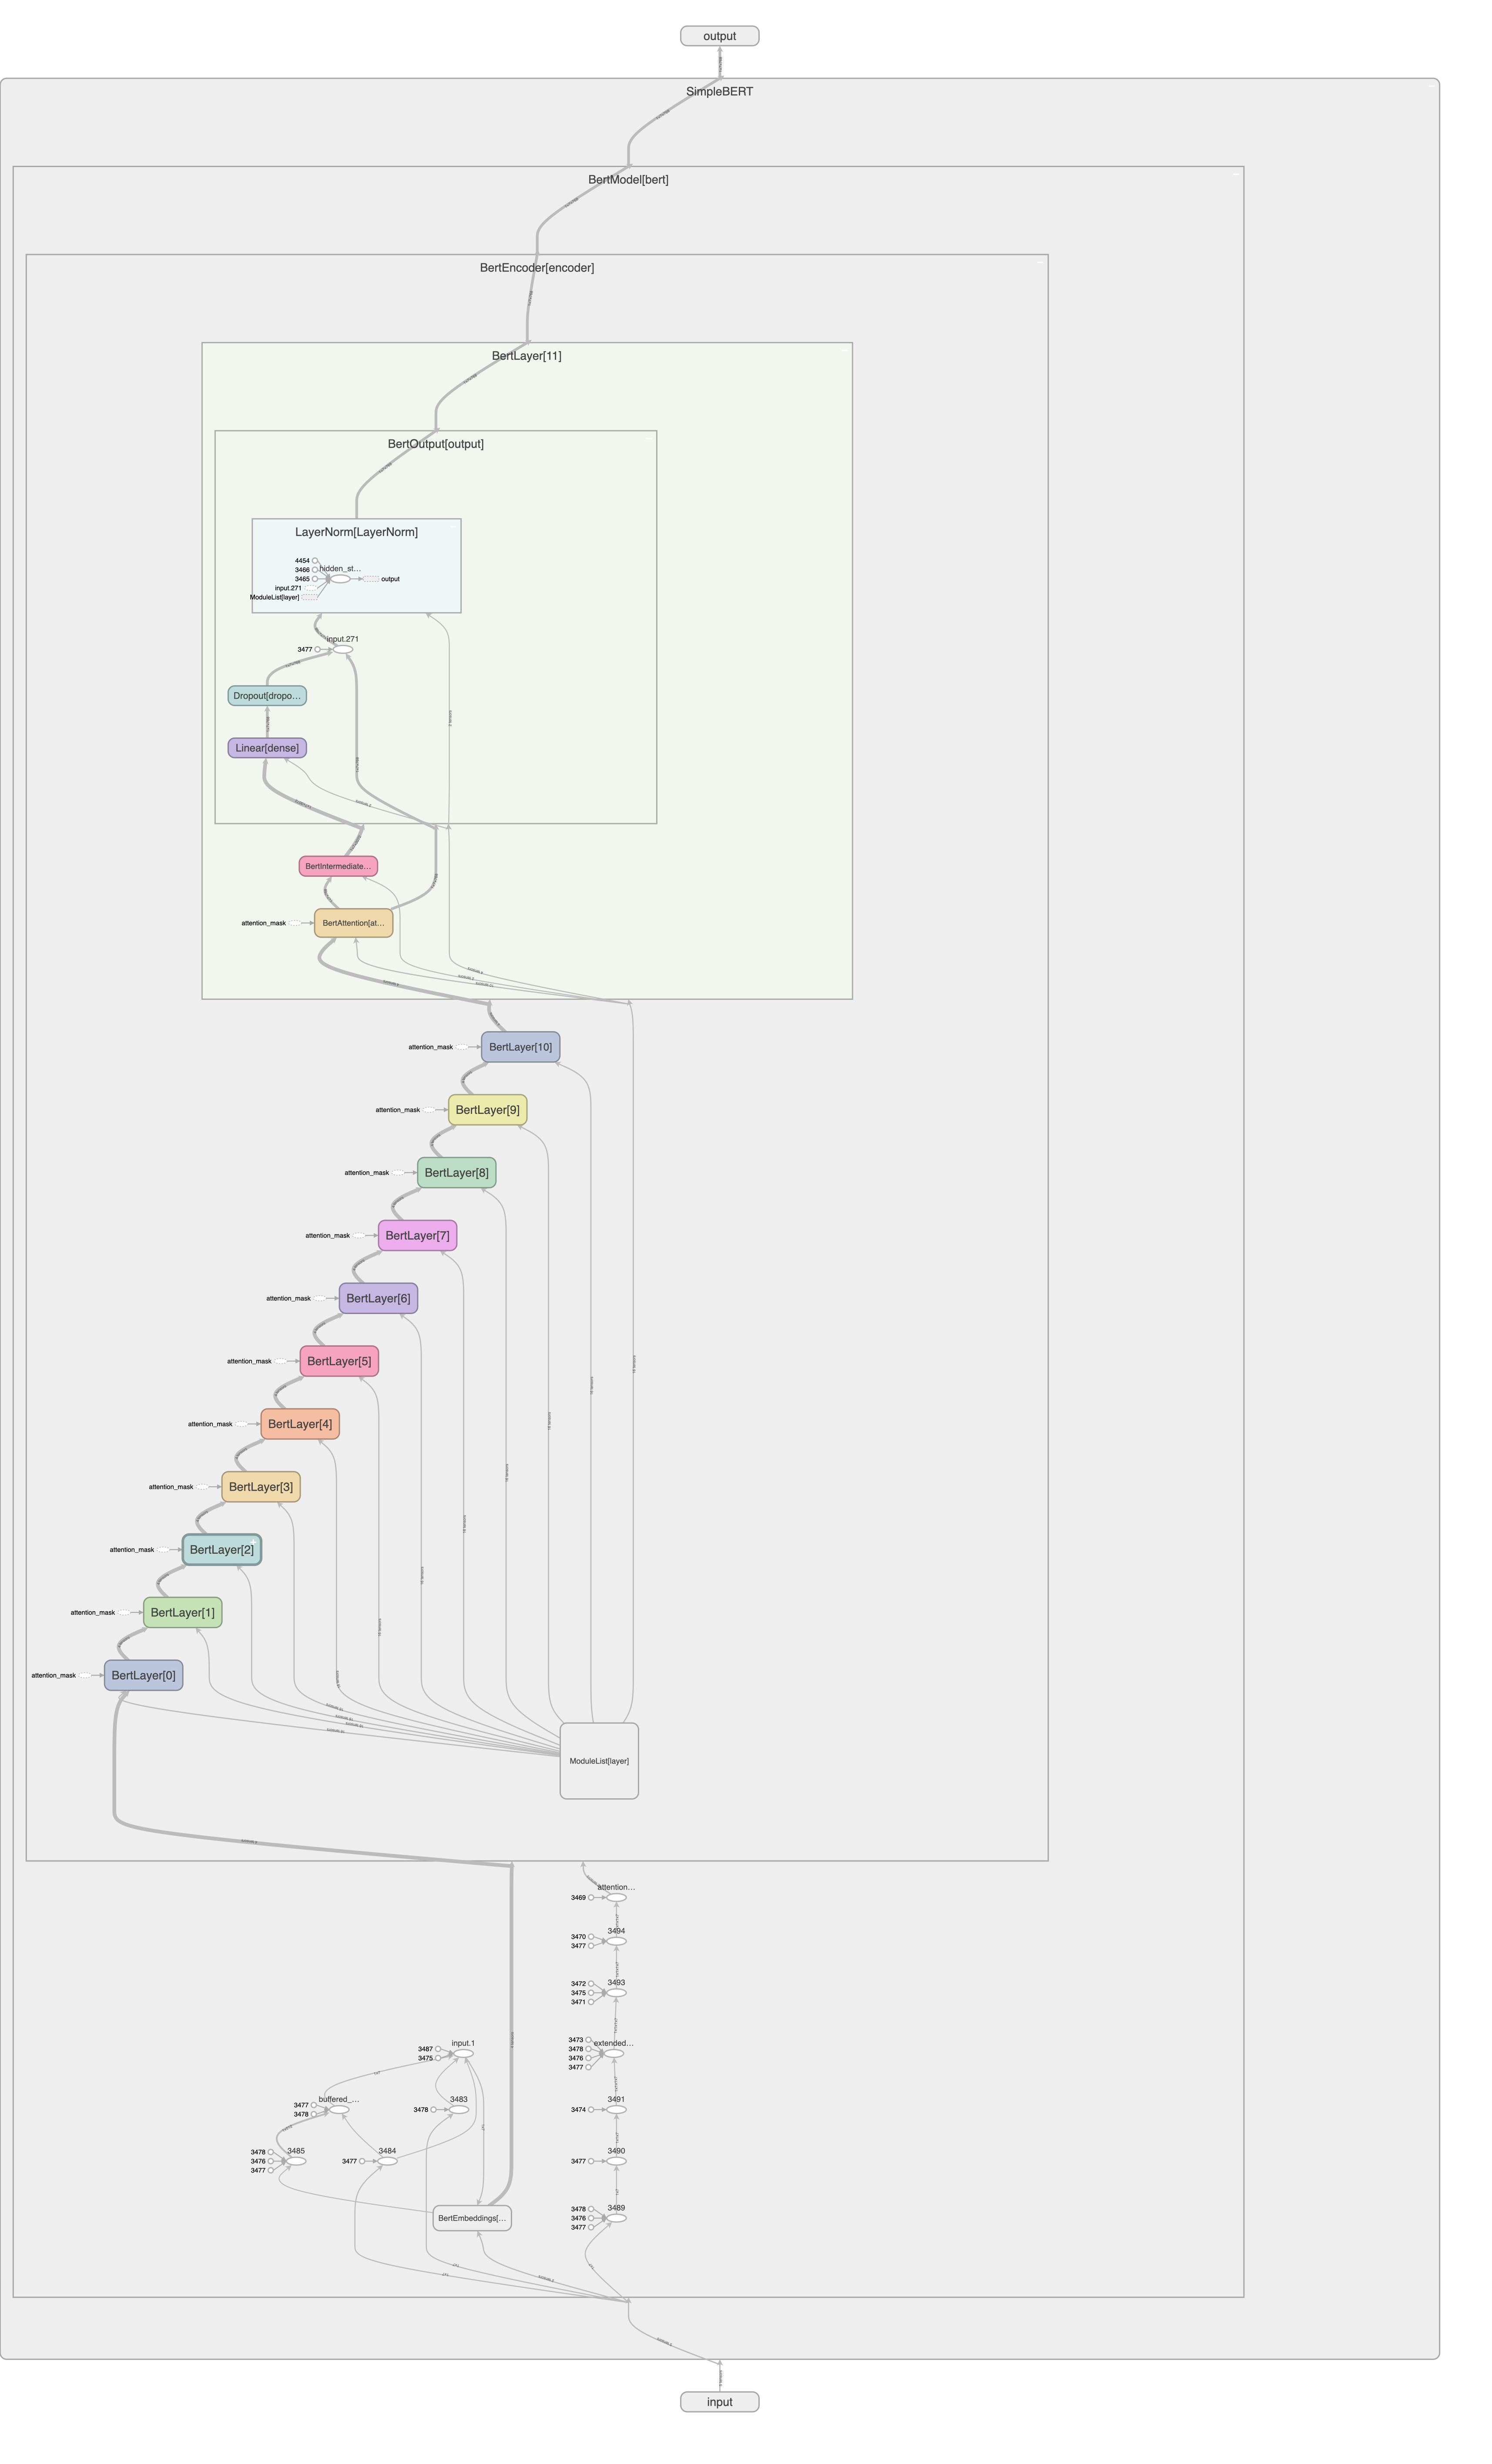

In [5]:
import torchvision
images = torch.randn(32, 3, 64, 64) # Simulating a batch of 32 images
grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid, 0)


# Visualize Histogram

In [8]:
for name, weight in model.named_parameters():
    writer.add_histogram(name, weight, epoch)

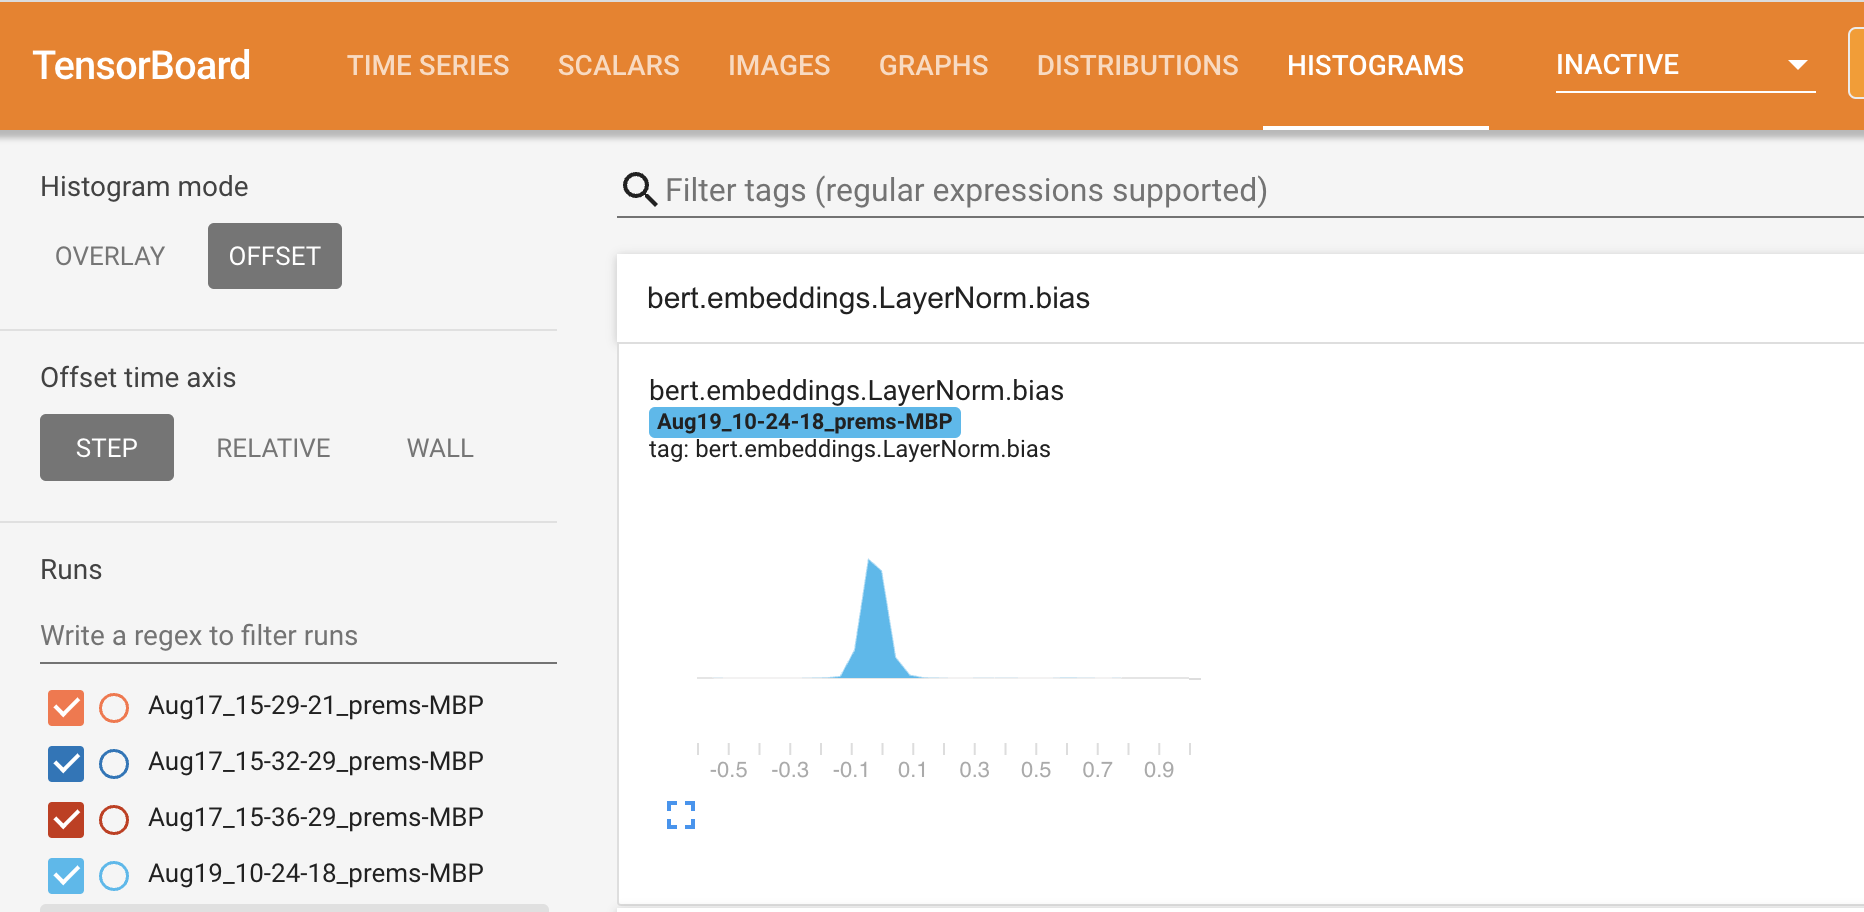

# Log Text

In [9]:
writer.add_text('Loss_Text', 'The training loss was very low this epoch', epoch)


# Visualize Embedding

In [11]:
import torch
from transformers import BertModel, BertTokenizer
from torch.utils.tensorboard import SummaryWriter

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
bert_model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

class SimpleBERT(torch.nn.Module):
    def __init__(self, bert_model):
        super(SimpleBERT, self).__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state

model = SimpleBERT(bert_model)

# Instantiate the SummaryWriter
writer = SummaryWriter()

# Create a dummy input for the BERT model
text = "I am fun and Happy"
tokens = tokenizer(text, return_tensors="pt")
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

# Get embeddings using the model
with torch.no_grad():
    embeddings = model(input_ids, attention_mask=attention_mask)

# Just as an example, using the tokens as metadata
# Note: We remove the [CLS] and [SEP] tokens for visualization.
metadata = [token for token in tokenizer.tokenize(text)]
embeddings = embeddings[0, 1:-1, :]  # Removing embeddings for [CLS] and [SEP]

writer.add_embedding(embeddings, metadata=metadata)

# Close the writer
writer.close()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


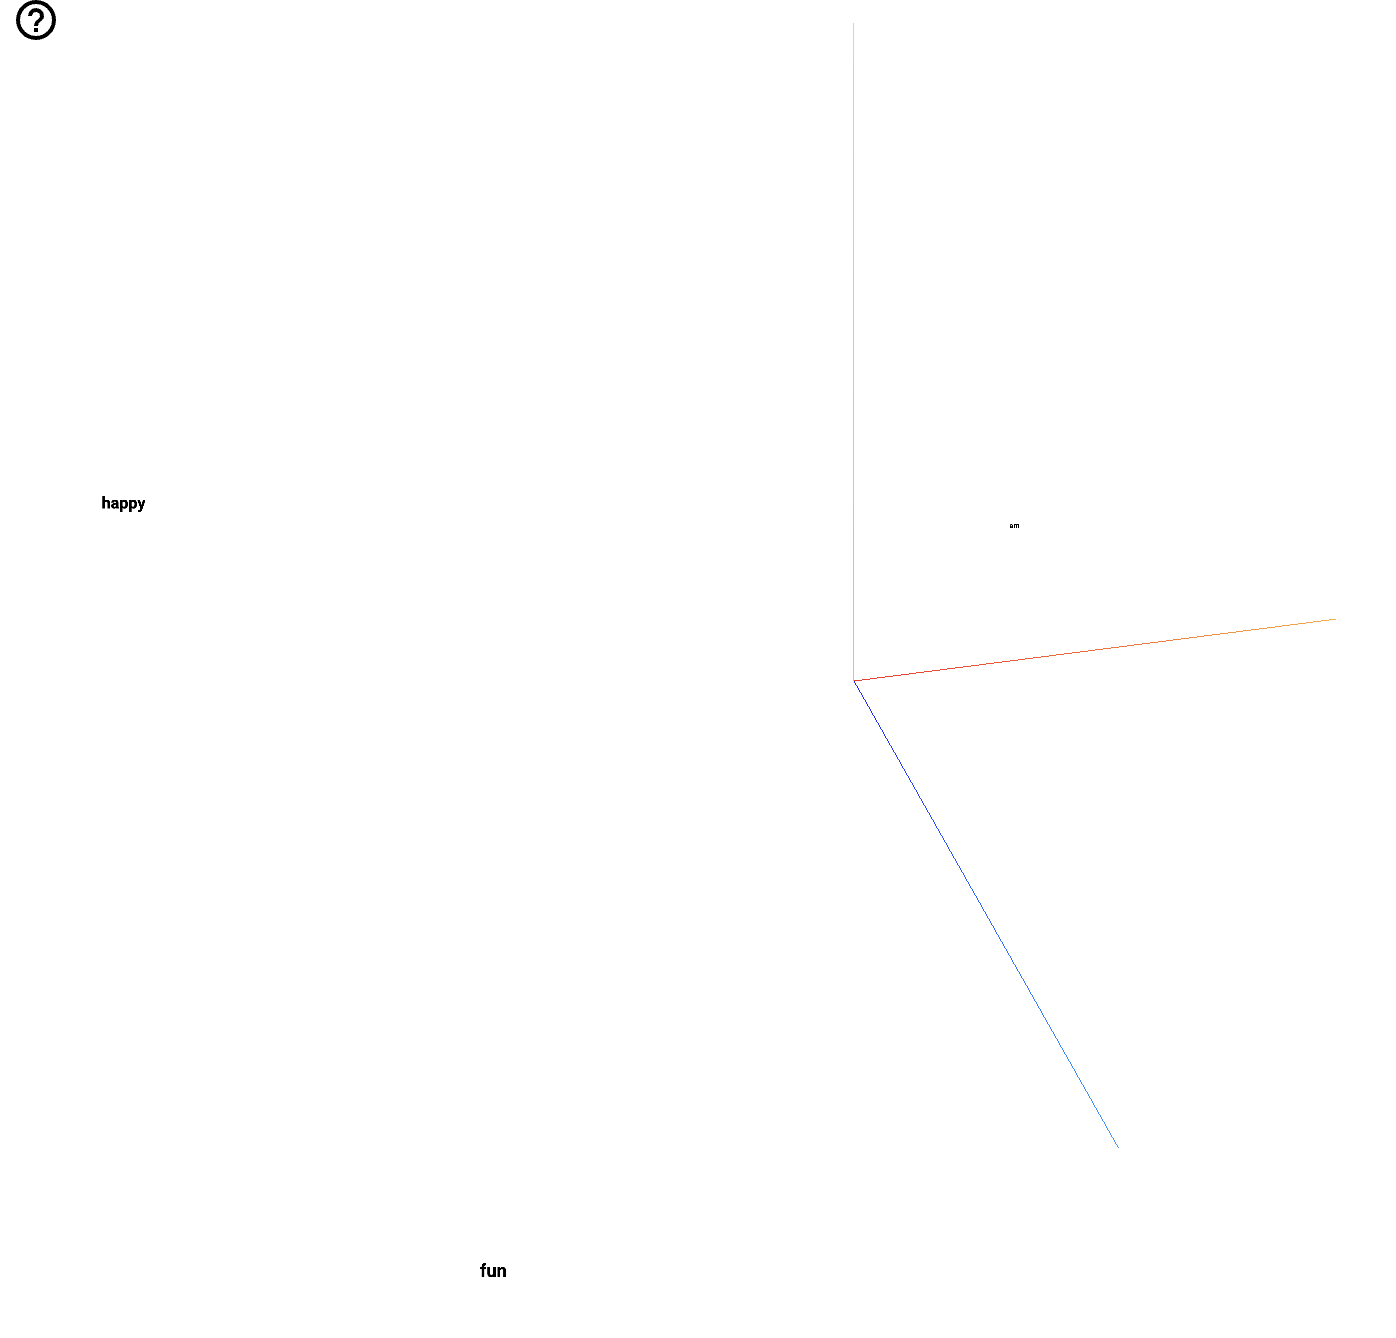

# Visualizing PR Curve

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

# Parameters
input_dim = 10
num_samples = 1000
batch_size = 32
num_epochs = 5

# Generate a dummy dataset
input_data = torch.randn(num_samples, input_dim)
# Create some dummy binary labels
true_labels = torch.randint(0, 2, (num_samples,)).float()

# Define a simple binary classification model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

model = SimpleModel()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# DataLoader
dataset = TensorDataset(input_data, true_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate TensorBoard writer
writer = SummaryWriter()

# Training loop
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # At the end of each epoch, compute probabilities for the entire dataset
    with torch.no_grad():
        probs = model(input_data).squeeze()
        writer.add_pr_curve('pr_curve', true_labels, probs, epoch)

# Close the writer
writer.close()


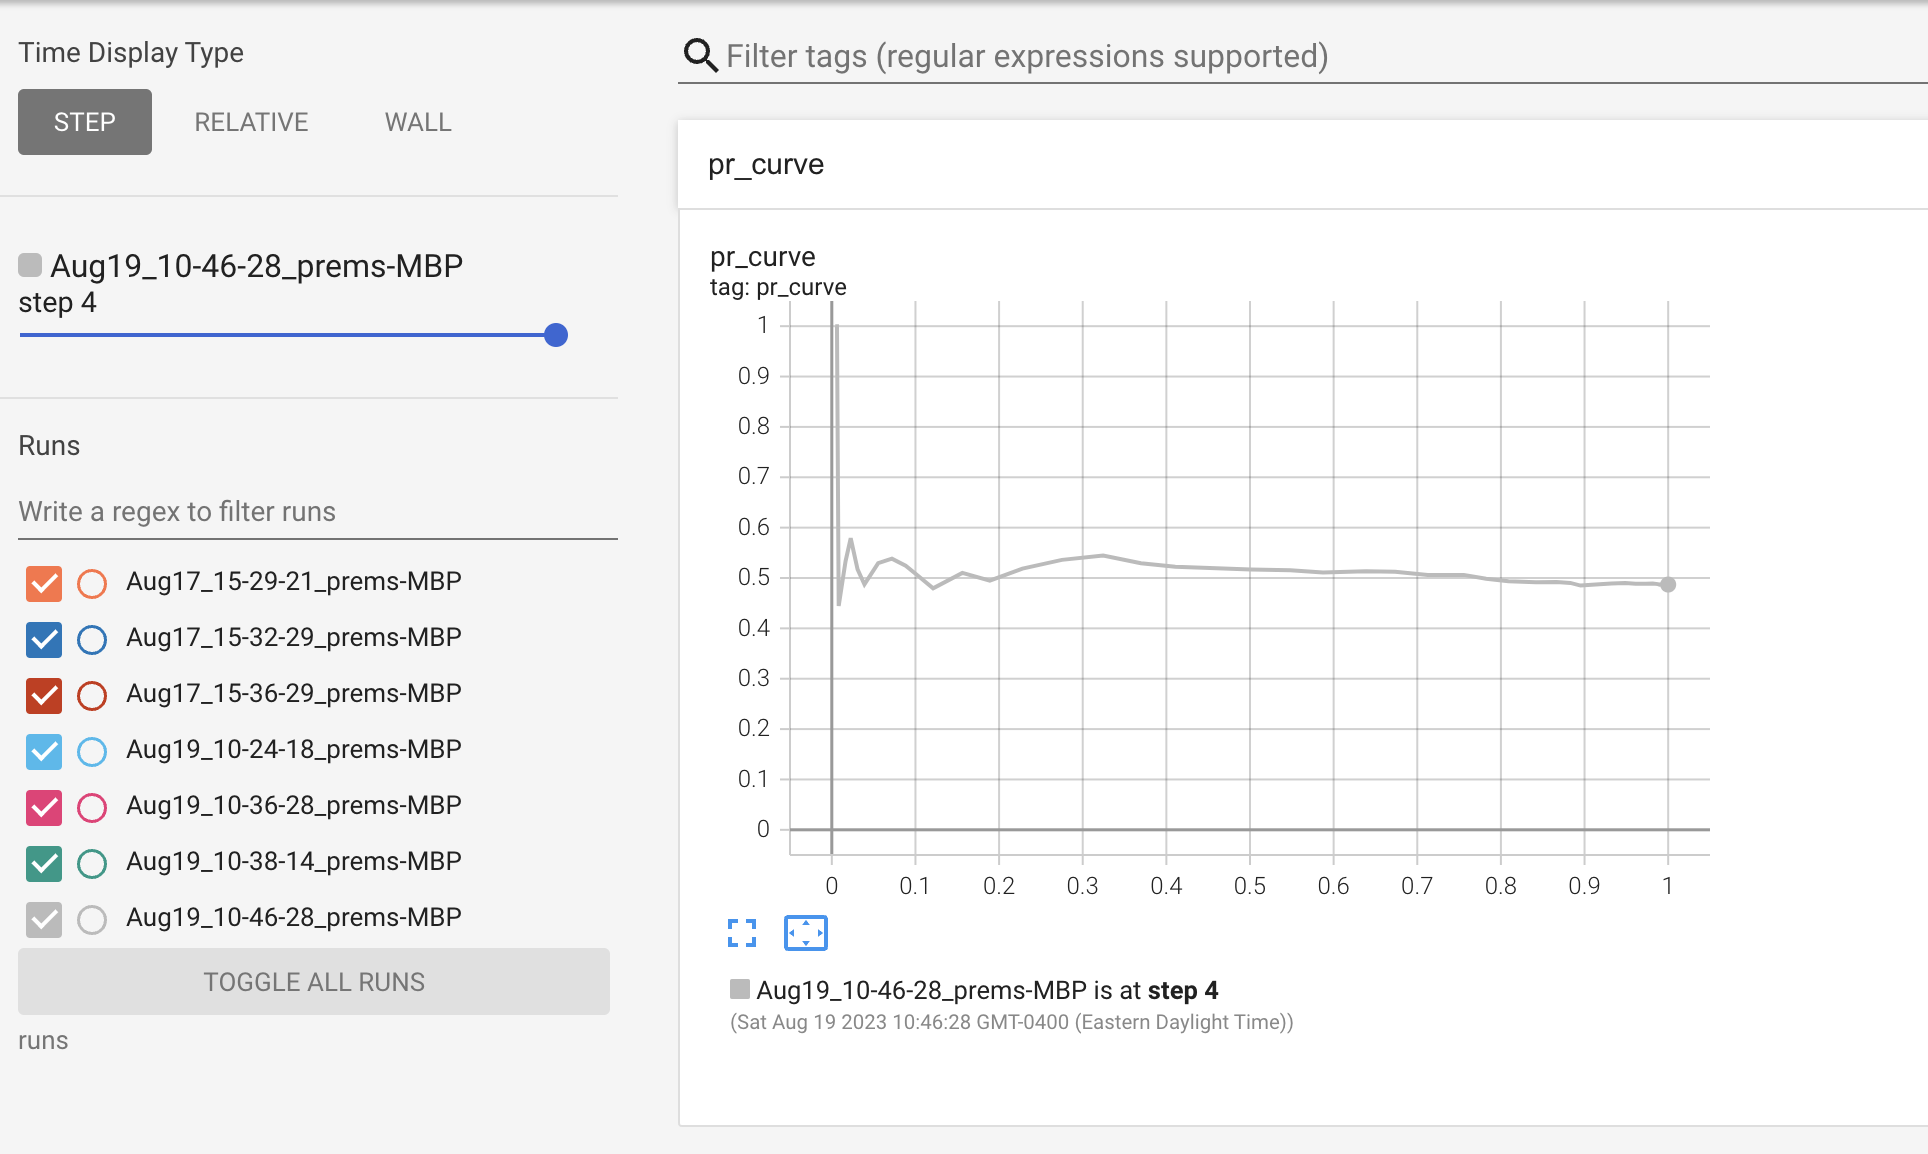

# Profiling

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

# Parameters
input_dim = 10
num_samples = 1000
batch_size = 32
num_epochs = 1

# Generate a dummy dataset
input_data = torch.randn(num_samples, input_dim)
# Create some dummy targets
targets = torch.randn(num_samples, 1)

# DataLoader
dataset = TensorDataset(input_data, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define a simple regression model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)

model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Instantiate TensorBoard writer
writer = SummaryWriter()

# Training step function
def train_step(inputs, targets):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop with profiling
for inputs, targets in dataloader:
    with torch.profiler.profile(with_stack=True) as prof:
        train_step(inputs, targets)

    # Log the profiling results to TensorBoard
    writer.add_text("Profile", str(prof.key_averages().table()))

# Close the writer
writer.close()


STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-08-19 10:59:06 19747:2466379 ActivityProfilerCo

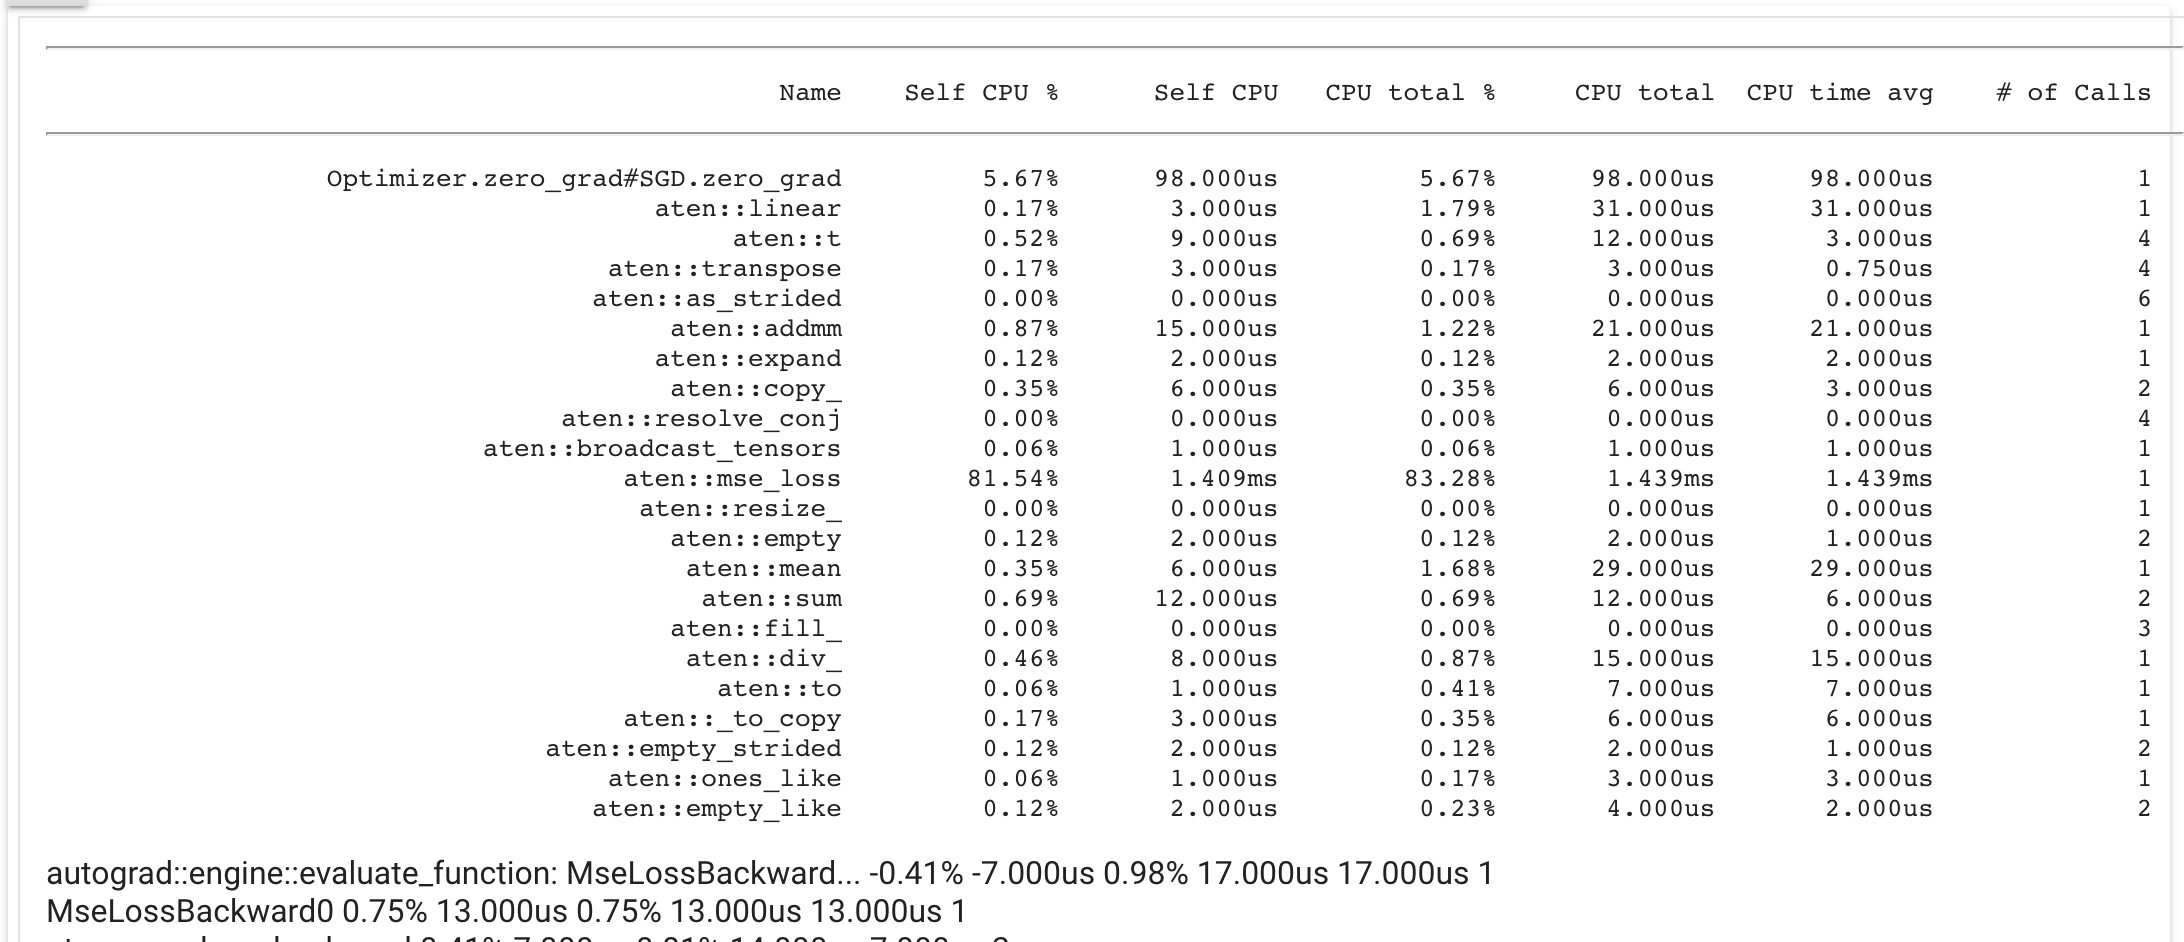